# Load Libraries

In [1]:
import os
os.sched_setaffinity(0, range(0,24))

from pathlib import Path

import pandas as pd
import polars as pl

import lightgbm as lgb
import matplotlib.pyplot as plt
import random
import seaborn as sns

from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Logging
import logging

# Get logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
file_handler = logging.FileHandler('logs.log')

# Set log format
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Settings to display log on notebook
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Data Load

In [2]:
INPUT_DIR = Path("/home/code_for_sub/3.ablation/1.leaky")

trn_df = pl.read_parquet(INPUT_DIR / "train" / "trn_df.parquet")
val_df = pl.read_parquet(INPUT_DIR / "validation" / "val_df.parquet")

# Train

In [3]:
trn_df.columns

['impression_id',
 'impression_time',
 'read_time',
 'scroll_percentage',
 'device_type',
 'user_id',
 'is_sso_user',
 'gender',
 'postcode',
 'age',
 'is_subscriber',
 'session_id',
 'count_article_ids_inview',
 'is_clicked',
 'article_id',
 'article_read_count',
 'article_last_read_time_diff',
 'article_read_count_v2',
 'cooccur_count_sum',
 'cooccur_count_mean',
 'cooccur_count_max',
 'cooccur_count_min',
 'cooccur_count_std',
 'cooccur_count_sum_norm',
 'cooccur_count_mean_norm',
 'cooccur_count_max_norm',
 'cooccur_count_min_norm',
 'cooccur_count_std_norm',
 'premium',
 'total_inviews',
 'total_pageviews',
 'total_read_time',
 'number_of_images',
 'article_label_positive_score',
 'article_label_negative_score',
 'article_label_neutral_score',
 'published_time_diff',
 'total_inviews_norm',
 'total_pageviews_norm',
 'total_read_time_norm',
 'published_time_diff_norm',
 'is_premium_subscriber',
 'category',
 'user_last_impression_time-publish_time_diff',
 'rounded_1m_inview_count',


In [4]:
target_col = 'is_clicked'

feature_cols = [
#     'impression_id',
#     'impression_time',
#     'read_time',  # read_time系は追加しても良いかも
#     'scroll_percentage',  # scroll_percentage系は追加しても良いかも
    'device_type',
#     'user_id',
    'is_sso_user',
    'gender',
    'postcode',
    'age',
    'is_subscriber',
#     'session_id',
    'count_article_ids_inview',
#     'is_clicked',
#     'article_id',
    'article_read_count',
    'article_last_read_time_diff',
    'article_read_count_v2',
#     'cooccur_count_sum',
#     'cooccur_count_mean',
#     'cooccur_count_max',
#     'cooccur_count_min',
#     'cooccur_count_std',
#     'cooccur_count_sum_norm',
#     'cooccur_count_mean_norm',
#     'cooccur_count_max_norm',
#     'cooccur_count_min_norm',
#     'cooccur_count_std_norm',
    'premium',
#     'total_inviews',
#     'total_pageviews',
#     'total_read_time',
    'number_of_images',
    'article_label_positive_score',
    'article_label_negative_score',
    'article_label_neutral_score',
    'published_time_diff',
#     'total_inviews_norm',
#     'total_pageviews_norm',
#     'total_read_time_norm',
    'published_time_diff_norm',
    'is_premium_subscriber',
    'category',
    'user_last_impression_time-publish_time_diff',
#     'rounded_1m_inview_count',
#     'rounded_1m_inview_count_norm',
#     'rounded_2m_inview_count',
#     'rounded_2m_inview_count_norm',
#     'rounded_3m_inview_count',
#     'rounded_3m_inview_count_norm',
#     'rounded_5m_inview_count',
#     'rounded_5m_inview_count_norm',
#     'rounded_10m_inview_count',
#     'rounded_10m_inview_count_norm',
#     'rounded_15m_inview_count',
#     'rounded_15m_inview_count_norm',
#     'rounded_20m_inview_count',
#     'rounded_20m_inview_count_norm',
#     'rounded_30m_inview_count',
#     'rounded_30m_inview_count_norm',
#     'rounded_1h_inview_count',
#     'rounded_1h_inview_count_norm',
#     'rounded_2h_inview_count',
#     'rounded_2h_inview_count_norm',
#     'rounded_3h_inview_count',
#     'rounded_3h_inview_count_norm',
#     'rounded_6h_inview_count',
#     'rounded_6h_inview_count_norm',
#     'rounded_12h_inview_count',
#     'rounded_12h_inview_count_norm',
#     'rounded_24h_inview_count',
#     'rounded_24h_inview_count_norm',
    'past_category_count',
    'max_past_category_count_count',
    'past_category_ratio',
#     'next_impression_id_mean_cossim',
#     'next_impression_id_min_cossim',
#     'next_impression_id_max_cossim',
    'click_cossim_multilingual-e5-large-instruct_mean_1',
    'click_cossim_multilingual-e5-large-instruct_mean_0',
    'category_click_cossim_multilingual-e5-large-instruct_mean',
    'click_cossim_multilingual-e5-large-instruct_scroll_mean_0',
    'category_click_cossim_multilingual-e5-large-instruct_scroll_mean',
    'click_cossim_multilingual-e5-large-instruct_read_time_mean_0',
    'category_click_cossim_multilingual-e5-large-instruct_read_time_mean',
#     'inview_cossim_multilingual-e5-large-instruct_user_id',
#     'inview_cossim_multilingual-e5-large-instruct_session_id',
#     'inview_cossim_multilingual-e5-large-instruct_impression_id',
    'multilingual-e5-large-instruct_individual_max_cossim_norm',
    'multilingual-e5-large-instruct_individual_min_cossim_norm',
    'multilingual-e5-large-instruct_individual_mean_cossim_norm',
    'multilingual-e5-large-instruct_individual_median_cossim_norm',
    'multilingual-e5-large-instruct_individual_quantile_q10_cossim_norm',
    'multilingual-e5-large-instruct_individual_quantile_q25_cossim_norm',
    'multilingual-e5-large-instruct_individual_quantile_q75_cossim_norm',
    'multilingual-e5-large-instruct_individual_quantile_q90_cossim_norm',
    'click_cossim_item2vec_mean_1',
    'click_cossim_item2vec_mean_2',
    'click_cossim_item2vec_mean_3',
    'click_cossim_item2vec_mean_0',
    'click_cossim_item2vec_scroll_mean_2',
    'click_cossim_item2vec_scroll_mean_3',
    'click_cossim_item2vec_scroll_mean_0',
    'click_cossim_item2vec_read_time_mean_2',
    'click_cossim_item2vec_read_time_mean_3',
    'click_cossim_item2vec_read_time_mean_0',
#     'cossim__multilingual-e5-large-instruct__device_type',
#     'cossim__multilingual-e5-large-instruct__is_subscriber',
#     'cossim__multilingual-e5-large-instruct__is_sso_user',
#     'inview_count',
    'past_inview_count',
    'time_gap_to_next_inview_impression_time',  # 列名がnextではなくprev？
#     'time_gap_from_prev_inview_impression_time',  # こちらがnextと思われる
#     'total_inviews_max',
#     'total_inviews_min',
#     'total_inviews_mean',
#     'total_inviews_median',
#     'total_inviews_std',
#     'total_inviews_skew',
#     'total_inviews_kurtosis',
#     'total_pageviews_max',
#     'total_pageviews_min',
#     'total_pageviews_mean',
#     'total_pageviews_median',
#     'total_pageviews_std',
#     'total_pageviews_skew',
#     'total_pageviews_kurtosis',
#     'total_read_time_max',
#     'total_read_time_min',
#     'total_read_time_mean',
#     'total_read_time_median',
#     'total_read_time_std',
#     'total_read_time_skew',
#     'total_read_time_kurtosis',
#     'rounded_1m_inview_count_max',
#     'rounded_1m_inview_count_min',
#     'rounded_1m_inview_count_mean',
#     'rounded_1m_inview_count_median',
#     'rounded_1m_inview_count_std',
#     'rounded_1m_inview_count_skew',
#     'rounded_1m_inview_count_kurtosis',
#     'rounded_2m_inview_count_max',
#     'rounded_2m_inview_count_min',
#     'rounded_2m_inview_count_mean',
#     'rounded_2m_inview_count_median',
#     'rounded_2m_inview_count_std',
#     'rounded_2m_inview_count_skew',
#     'rounded_2m_inview_count_kurtosis',
#     'rounded_3m_inview_count_max',
#     'rounded_3m_inview_count_min',
#     'rounded_3m_inview_count_mean',
#     'rounded_3m_inview_count_median',
#     'rounded_3m_inview_count_std',
#     'rounded_3m_inview_count_skew',
#     'rounded_3m_inview_count_kurtosis',
#     'rounded_5m_inview_count_max',
#     'rounded_5m_inview_count_min',
#     'rounded_5m_inview_count_mean',
#     'rounded_5m_inview_count_median',
#     'rounded_5m_inview_count_std',
#     'rounded_5m_inview_count_skew',
#     'rounded_5m_inview_count_kurtosis',
#     'rounded_10m_inview_count_max',
#     'rounded_10m_inview_count_min',
#     'rounded_10m_inview_count_mean',
#     'rounded_10m_inview_count_median',
#     'rounded_10m_inview_count_std',
#     'rounded_10m_inview_count_skew',
#     'rounded_10m_inview_count_kurtosis',
#     'rounded_15m_inview_count_max',
#     'rounded_15m_inview_count_min',
#     'rounded_15m_inview_count_mean',
#     'rounded_15m_inview_count_median',
#     'rounded_15m_inview_count_std',
#     'rounded_15m_inview_count_skew',
#     'rounded_15m_inview_count_kurtosis',
#     'rounded_20m_inview_count_max',
#     'rounded_20m_inview_count_min',
#     'rounded_20m_inview_count_mean',
#     'rounded_20m_inview_count_median',
#     'rounded_20m_inview_count_std',
#     'rounded_20m_inview_count_skew',
#     'rounded_20m_inview_count_kurtosis',
#     'rounded_30m_inview_count_max',
#     'rounded_30m_inview_count_min',
#     'rounded_30m_inview_count_mean',
#     'rounded_30m_inview_count_median',
#     'rounded_30m_inview_count_std',
#     'rounded_30m_inview_count_skew',
#     'rounded_30m_inview_count_kurtosis',
#     'rounded_1h_inview_count_max',
#     'rounded_1h_inview_count_min',
#     'rounded_1h_inview_count_mean',
#     'rounded_1h_inview_count_median',
#     'rounded_1h_inview_count_std',
#     'rounded_1h_inview_count_skew',
#     'rounded_1h_inview_count_kurtosis',
#     'rounded_3h_inview_count_max',
#     'rounded_3h_inview_count_min',
#     'rounded_3h_inview_count_mean',
#     'rounded_3h_inview_count_median',
#     'rounded_3h_inview_count_std',
#     'rounded_3h_inview_count_skew',
#     'rounded_3h_inview_count_kurtosis',
#     'rounded_6h_inview_count_max',
#     'rounded_6h_inview_count_min',
#     'rounded_6h_inview_count_mean',
#     'rounded_6h_inview_count_median',
#     'rounded_6h_inview_count_std',
#     'rounded_6h_inview_count_skew',
#     'rounded_6h_inview_count_kurtosis',
#     'rounded_12h_inview_count_max',
#     'rounded_12h_inview_count_min',
#     'rounded_12h_inview_count_mean',
#     'rounded_12h_inview_count_median',
#     'rounded_12h_inview_count_std',
#     'rounded_12h_inview_count_skew',
#     'rounded_12h_inview_count_kurtosis',
#     'rounded_24h_inview_count_max',
#     'rounded_24h_inview_count_min',
#     'rounded_24h_inview_count_mean',
#     'rounded_24h_inview_count_median',
#     'rounded_24h_inview_count_std',
#     'rounded_24h_inview_count_skew',
#     'rounded_24h_inview_count_kurtosis',
#     'inview_count_max',
#     'inview_count_min',
#     'inview_count_mean',
#     'inview_count_median',
#     'inview_count_std',
#     'inview_count_skew',
#     'inview_count_kurtosis',
    'past_inview_count_max',
    'past_inview_count_min',
    'past_inview_count_mean',
    'past_inview_count_median',
    'past_inview_count_std',
    'past_inview_count_skew',
    'past_inview_count_kurtosis',
    'time_gap_to_next_inview_impression_time_max',
    'time_gap_to_next_inview_impression_time_min',
    'time_gap_to_next_inview_impression_time_mean',
    'time_gap_to_next_inview_impression_time_median',
    'time_gap_to_next_inview_impression_time_std',
    'time_gap_to_next_inview_impression_time_skew',
    'time_gap_to_next_inview_impression_time_kurtosis',
#     'time_gap_from_prev_inview_impression_time_max',
#     'time_gap_from_prev_inview_impression_time_min',
#     'time_gap_from_prev_inview_impression_time_mean',
#     'time_gap_from_prev_inview_impression_time_median',
#     'time_gap_from_prev_inview_impression_time_std',
#     'time_gap_from_prev_inview_impression_time_skew',
#     'time_gap_from_prev_inview_impression_time_kurtosis',
    'published_time_diff_max',
    'published_time_diff_min',
    'published_time_diff_mean',
    'published_time_diff_median',
    'published_time_diff_std',
    'published_time_diff_skew',
    'published_time_diff_kurtosis',
#     'rounded_1m_inview_count_max-rounded_1m_inview_count',
#     'rounded_1m_inview_count_max/rounded_1m_inview_count',
#     'rounded_1m_inview_count_mean-rounded_1m_inview_count',
#     'rounded_1m_inview_count_mean/rounded_1m_inview_count',
#     'rounded_1m_inview_count_median-rounded_1m_inview_count',
#     'rounded_1m_inview_count_median/rounded_1m_inview_count',
#     'rounded_1m_inview_count_min-rounded_1m_inview_count',
#     'rounded_1m_inview_count_min/rounded_1m_inview_count',
#     'rounded_2m_inview_count_max-rounded_2m_inview_count',
#     'rounded_2m_inview_count_max/rounded_2m_inview_count',
#     'rounded_2m_inview_count_mean-rounded_2m_inview_count',
#     'rounded_2m_inview_count_mean/rounded_2m_inview_count',
#     'rounded_2m_inview_count_median-rounded_2m_inview_count',
#     'rounded_2m_inview_count_median/rounded_2m_inview_count',
#     'rounded_2m_inview_count_min-rounded_2m_inview_count',
#     'rounded_2m_inview_count_min/rounded_2m_inview_count',
#     'rounded_3m_inview_count_max-rounded_3m_inview_count',
#     'rounded_3m_inview_count_max/rounded_3m_inview_count',
#     'rounded_3m_inview_count_mean-rounded_3m_inview_count',
#     'rounded_3m_inview_count_mean/rounded_3m_inview_count',
#     'rounded_3m_inview_count_median-rounded_3m_inview_count',
#     'rounded_3m_inview_count_median/rounded_3m_inview_count',
#     'rounded_3m_inview_count_min-rounded_3m_inview_count',
#     'rounded_3m_inview_count_min/rounded_3m_inview_count',
#     'rounded_5m_inview_count_max-rounded_5m_inview_count',
#     'rounded_5m_inview_count_max/rounded_5m_inview_count',
#     'rounded_5m_inview_count_mean-rounded_5m_inview_count',
#     'rounded_5m_inview_count_mean/rounded_5m_inview_count',
#     'rounded_5m_inview_count_median-rounded_5m_inview_count',
#     'rounded_5m_inview_count_median/rounded_5m_inview_count',
#     'rounded_5m_inview_count_min-rounded_5m_inview_count',
#     'rounded_5m_inview_count_min/rounded_5m_inview_count',
#     'rounded_10m_inview_count_max-rounded_10m_inview_count',
#     'rounded_10m_inview_count_max/rounded_10m_inview_count',
#     'rounded_10m_inview_count_mean-rounded_10m_inview_count',
#     'rounded_10m_inview_count_mean/rounded_10m_inview_count',
#     'rounded_10m_inview_count_median-rounded_10m_inview_count',
#     'rounded_10m_inview_count_median/rounded_10m_inview_count',
#     'rounded_10m_inview_count_min-rounded_10m_inview_count',
#     'rounded_10m_inview_count_min/rounded_10m_inview_count',
#     'rounded_15m_inview_count_max-rounded_15m_inview_count',
#     'rounded_15m_inview_count_max/rounded_15m_inview_count',
#     'rounded_15m_inview_count_mean-rounded_15m_inview_count',
#     'rounded_15m_inview_count_mean/rounded_15m_inview_count',
#     'rounded_15m_inview_count_median-rounded_15m_inview_count',
#     'rounded_15m_inview_count_median/rounded_15m_inview_count',
#     'rounded_15m_inview_count_min-rounded_15m_inview_count',
#     'rounded_15m_inview_count_min/rounded_15m_inview_count',
#     'rounded_20m_inview_count_max-rounded_20m_inview_count',
#     'rounded_20m_inview_count_max/rounded_20m_inview_count',
#     'rounded_20m_inview_count_mean-rounded_20m_inview_count',
#     'rounded_20m_inview_count_mean/rounded_20m_inview_count',
#     'rounded_20m_inview_count_median-rounded_20m_inview_count',
#     'rounded_20m_inview_count_median/rounded_20m_inview_count',
#     'rounded_20m_inview_count_min-rounded_20m_inview_count',
#     'rounded_20m_inview_count_min/rounded_20m_inview_count',
#     'rounded_30m_inview_count_max-rounded_30m_inview_count',
#     'rounded_30m_inview_count_max/rounded_30m_inview_count',
#     'rounded_30m_inview_count_mean-rounded_30m_inview_count',
#     'rounded_30m_inview_count_mean/rounded_30m_inview_count',
#     'rounded_30m_inview_count_median-rounded_30m_inview_count',
#     'rounded_30m_inview_count_median/rounded_30m_inview_count',
#     'rounded_30m_inview_count_min-rounded_30m_inview_count',
#     'rounded_30m_inview_count_min/rounded_30m_inview_count',
#     'rounded_1h_inview_count_max-rounded_1h_inview_count',
#     'rounded_1h_inview_count_max/rounded_1h_inview_count',
#     'rounded_1h_inview_count_mean-rounded_1h_inview_count',
#     'rounded_1h_inview_count_mean/rounded_1h_inview_count',
#     'rounded_1h_inview_count_median-rounded_1h_inview_count',
#     'rounded_1h_inview_count_median/rounded_1h_inview_count',
#     'rounded_1h_inview_count_min-rounded_1h_inview_count',
#     'rounded_1h_inview_count_min/rounded_1h_inview_count',
#     'rounded_3h_inview_count_max-rounded_3h_inview_count',
#     'rounded_3h_inview_count_max/rounded_3h_inview_count',
#     'rounded_3h_inview_count_mean-rounded_3h_inview_count',
#     'rounded_3h_inview_count_mean/rounded_3h_inview_count',
#     'rounded_3h_inview_count_median-rounded_3h_inview_count',
#     'rounded_3h_inview_count_median/rounded_3h_inview_count',
#     'rounded_3h_inview_count_min-rounded_3h_inview_count',
#     'rounded_3h_inview_count_min/rounded_3h_inview_count',
#     'rounded_6h_inview_count_max-rounded_6h_inview_count',
#     'rounded_6h_inview_count_max/rounded_6h_inview_count',
#     'rounded_6h_inview_count_mean-rounded_6h_inview_count',
#     'rounded_6h_inview_count_mean/rounded_6h_inview_count',
#     'rounded_6h_inview_count_median-rounded_6h_inview_count',
#     'rounded_6h_inview_count_median/rounded_6h_inview_count',
#     'rounded_6h_inview_count_min-rounded_6h_inview_count',
#     'rounded_6h_inview_count_min/rounded_6h_inview_count',
#     'rounded_12h_inview_count_max-rounded_12h_inview_count',
#     'rounded_12h_inview_count_max/rounded_12h_inview_count',
#     'rounded_12h_inview_count_mean-rounded_12h_inview_count',
#     'rounded_12h_inview_count_mean/rounded_12h_inview_count',
#     'rounded_12h_inview_count_median-rounded_12h_inview_count',
#     'rounded_12h_inview_count_median/rounded_12h_inview_count',
#     'rounded_12h_inview_count_min-rounded_12h_inview_count',
#     'rounded_12h_inview_count_min/rounded_12h_inview_count',
#     'rounded_24h_inview_count_max-rounded_24h_inview_count',
#     'rounded_24h_inview_count_max/rounded_24h_inview_count',
#     'rounded_24h_inview_count_mean-rounded_24h_inview_count',
#     'rounded_24h_inview_count_mean/rounded_24h_inview_count',
#     'rounded_24h_inview_count_median-rounded_24h_inview_count',
#     'rounded_24h_inview_count_median/rounded_24h_inview_count',
#     'rounded_24h_inview_count_min-rounded_24h_inview_count',
#     'rounded_24h_inview_count_min/rounded_24h_inview_count',
#     'inview_count_max-inview_count',
#     'inview_count_max/inview_count',
#     'inview_count_mean-inview_count',
#     'inview_count_mean/inview_count',
#     'inview_count_median-inview_count',
#     'inview_count_median/inview_count',
#     'inview_count_min-inview_count',
#     'inview_count_min/inview_count',
    'past_inview_count_max-past_inview_count',
    'past_inview_count_max/past_inview_count',
    'past_inview_count_mean-past_inview_count',
    'past_inview_count_mean/past_inview_count',
    'past_inview_count_median-past_inview_count',
    'past_inview_count_median/past_inview_count',
    'past_inview_count_min-past_inview_count',
    'past_inview_count_min/past_inview_count',
    'time_gap_to_next_inview_impression_time_max-time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_max/time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_mean-time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_mean/time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_median-time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_median/time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_min-time_gap_to_next_inview_impression_time',
    'time_gap_to_next_inview_impression_time_min/time_gap_to_next_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_max-time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_max/time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_mean-time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_mean/time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_median-time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_median/time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_min-time_gap_from_prev_inview_impression_time',
#     'time_gap_from_prev_inview_impression_time_min/time_gap_from_prev_inview_impression_time',
    'published_time_diff_max-published_time_diff',
    'published_time_diff_max/published_time_diff',
    'published_time_diff_mean-published_time_diff',
    'published_time_diff_mean/published_time_diff',
    'published_time_diff_median-published_time_diff',
    'published_time_diff_median/published_time_diff',
    'published_time_diff_min-published_time_diff',
    'published_time_diff_min/published_time_diff',
#     'pageviews/inviews',
#     'read_time/inviews',
    'published_time_diff_rank',
#     'total_inviews_norm_rank',
#     'total_pageviews_norm_rank',
#     'total_read_time_norm_rank',
#     'rounded_1m_inview_count_rank',
#     'rounded_2m_inview_count_rank',
#     'rounded_3m_inview_count_rank',
#     'rounded_5m_inview_count_rank',
#     'rounded_10m_inview_count_rank',
#     'rounded_15m_inview_count_rank',
#     'rounded_20m_inview_count_rank',
#     'rounded_30m_inview_count_rank',
#     'rounded_1h_inview_count_rank',
#     'rounded_3h_inview_count_rank',
#     'rounded_6h_inview_count_rank',
#     'rounded_12h_inview_count_rank',
#     'rounded_24h_inview_count_rank',
#     'inview_count_rank',
    'past_inview_count_rank',
    'time_gap_to_next_inview_impression_time_rank',
#     'time_gap_from_prev_inview_impression_time_rank',
#     'next_impression_id_mean_cossim_rank',
#     'next_impression_id_min_cossim_rank',
#     'next_impression_id_max_cossim_rank',
    'published_time_diff_min-published_time_diff_rank',
    'hour',
    'minute',
    'second',
    'weekday',
#     'mean_count_article_ids_inview',
#     'min_count_article_ids_inview',
#     'median_count_article_ids_inview',
    'mean_history_published_time_diff',
    'max_history_published_time_diff',
    'min_history_published_time_diff',
    'median_history_published_time_diff',
]

In [5]:
X_train = trn_df.select(feature_cols).to_pandas()
y_train = trn_df[target_col].to_pandas()

imp_train = trn_df['impression_id'].to_pandas()

logger.info(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train["category"] = X_train["category"].astype("category")

[2024-07-07 06:21:01,596][INFO] X_train shape: (2585747, 107), y_train shape: (2585747,)


In [6]:
X_valid = val_df.select(feature_cols).to_pandas()
y_valid = val_df[target_col].to_pandas()

imp_valid = val_df['impression_id'].to_pandas()

logger.info(f'X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}')

X_valid["category"] = X_valid["category"].astype("category")

[2024-07-07 06:21:02,201][INFO] X_valid shape: (2928942, 107), y_valid shape: (2928942,)


In [7]:
from sklearn.metrics import roc_auc_score
def get_mean_auc(y_pred,y_true,impression):
    pred_df = pd.DataFrame({
        'impression_id': impression,
        'y_true': y_true,
        'y_pred': y_pred
    })

    #save as valid_pred.parquet
    pred_df.to_parquet('valid_pred.parquet')

    group_auc = pred_df.groupby('impression_id').apply(lambda x: roc_auc_score(x['y_true'],x['y_pred'])).mean()

    return group_auc

In [8]:
del trn_df, val_df
import gc; gc.collect()

63

## LightGBM

In [9]:
lgb_params ={
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at':5,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 758392,
    'n_jobs': 20,
}

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21182
[LightGBM] [Info] Number of data points in the train set: 2585747, number of used features: 107
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's ndcg@5: 0.750888
[200]	valid_0's ndcg@5: 0.754854
[300]	valid_0's ndcg@5: 0.757262
[400]	valid_0's ndcg@5: 0.758809
[500]	valid_0's ndcg@5: 0.760016
[600]	valid_0's ndcg@5: 0.761129
[700]	valid_0's ndcg@5: 0.762017
[800]	valid_0's ndcg@5: 0.762894
[900]	valid_0's ndcg@5: 0.763541
[1000]	valid_0's ndcg@5: 0.763979
[1100]	valid_0's ndcg@5: 0.764506
[1200]	valid_0's ndcg@5: 0.764707
[1300]	valid_0's ndcg@5: 0.765096
[1400]	valid_0's ndcg@5: 0.765393
[1500]	valid_0's ndcg@5: 0.765694
[1600]	valid_0's ndcg@5: 0.765789
[1700]	valid_0's ndcg@5: 0.765993
[1800]	v

[2024-07-07 06:33:25,332][INFO] best_iter: 4255, best_score: 0.7671737582136217


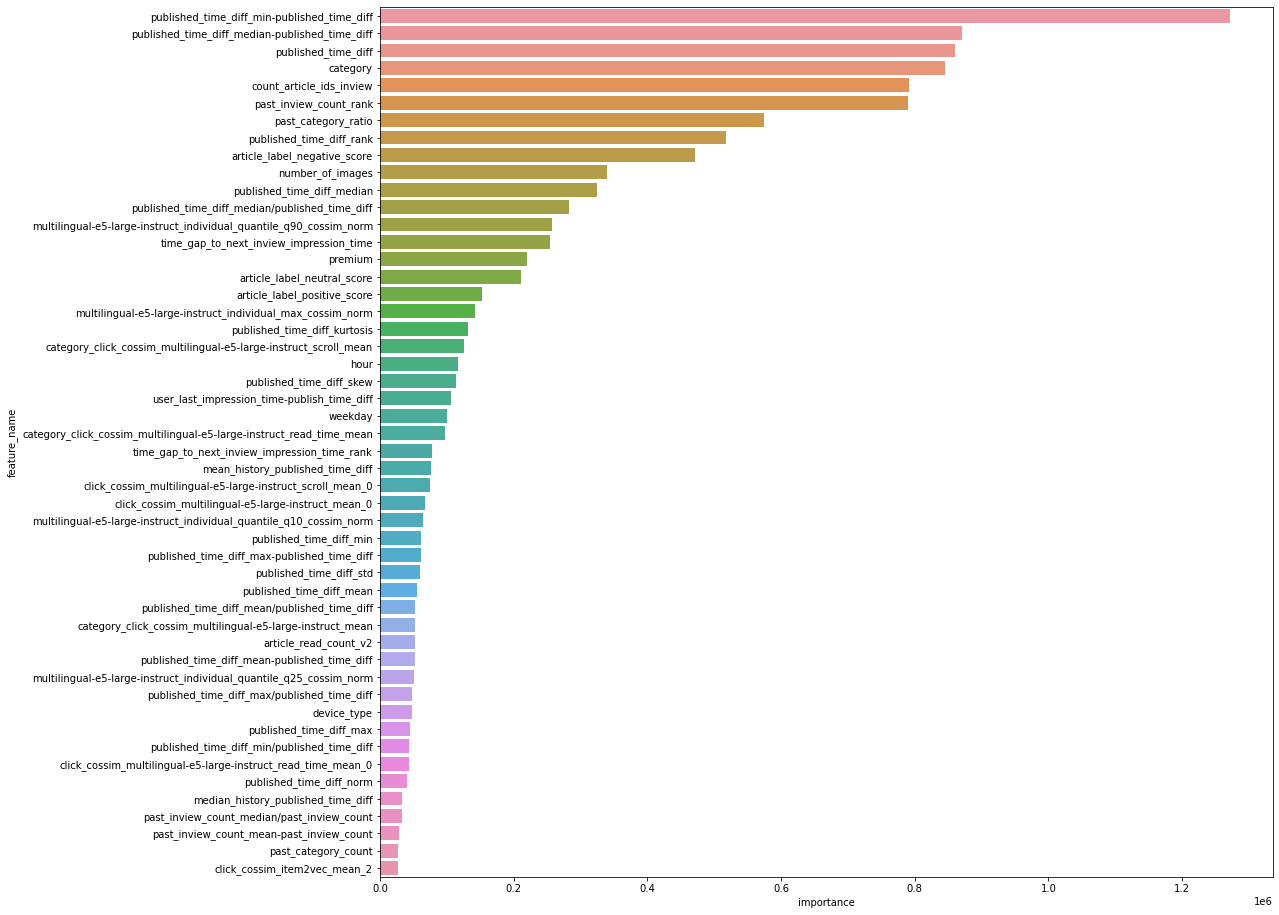

CPU times: user 3h 52min 3s, sys: 16.4 s, total: 3h 52min 19s
Wall time: 11min 49s


In [10]:
%%time
#train
callbacks = [
    lgb.early_stopping(stopping_rounds=1000, verbose=True),
    lgb.log_evaluation(period=100)
]

group_train = imp_train.groupby(imp_train).count().to_numpy()
group_valid = imp_valid.groupby(imp_valid).count().to_numpy()

lgb_train = lgb.Dataset(X_train, label=y_train,group=group_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid,group=group_valid, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_valid],
    num_boost_round=30000,
    callbacks=callbacks
)

#best_iter, best_score
best_iter = lgb_model.best_iteration
best_score = lgb_model.best_score['valid_0']['ndcg@5']

logger.info(f'best_iter: {best_iter}, best_score: {best_score}')

#feature importance
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_name = lgb_model.feature_name()
feature_importance_df = pd.DataFrame({
    'feature_name': feature_name,
    'importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df.to_csv('feature_importance.csv', index=False)

#plot
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.head(50), x='importance', y='feature_name')
plt.show()

In [11]:
lgb_model.save_model("lgb_model.txt")

In [12]:
group_auc = get_mean_auc(lgb_model.predict(X_valid),y_valid,imp_valid)
logger.info(f'group_auc: {group_auc}')

[2024-07-07 06:39:41,039][INFO] group_auc: 0.7775286584197888


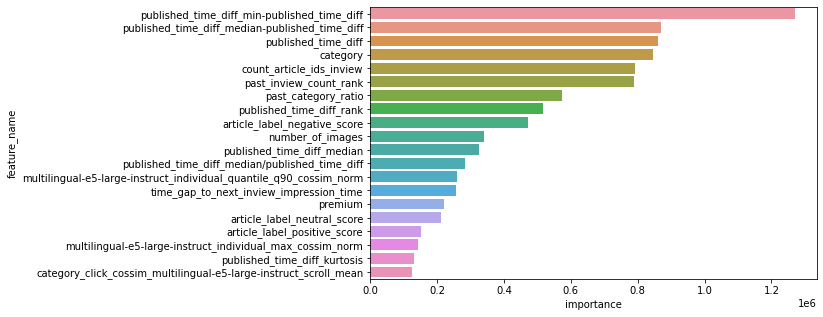

In [13]:
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature_name')
figure = bar_plot.get_figure()
figure.savefig("feature_importance_top20.png", bbox_inches='tight', dpi=150)